# Anime Recommendation System

## Objective: 
    To build a recommendation system by studying, praticing & comparing different approaches and algorithms.
    
    Sub-Objectives:
        - EDA, Data Mining
        - Practice Supervised/Unsupervised techniques



## Recommendation Systems:
    Problem: 
        - Identifying User's need
        - Excess/abundance of options/choices
   
    Solution: Recommend items that user most likely wants.

###### Types:
There are a lot of ideas in case of recommender sytems (recsys). Following are general types:

    - Content Based        
    - Collaborative Filtering (CF)
    - Hybrid Recommender Systems
    - Demographic Based
    - Utility Based
    - Knowledge Based
    
These systems can also be divided into following categories based on algorithmic approach:

    - Neighborhood Based
    - Latent Factor Model
    - Classification
    
Note: There are many variations/flavors of Recommender Systems depending on Data, Approach & Algorithms being used.


## Scope:    
For this project, I'll start with building a basic model. And move forward from there by applying more complex approaches and comparing the pros & cons along the way.


## RoadMap:
Data Set: Anime Recommendation

###### 1. Fetch Data:
    Files: 
        1. Anime.csv -> 'anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members
        2. Rating.csv -> 'user_id', 'anime_id', 'rating'

###### 2. Wrangle, Prepare and Cleanse Data

###### 3. Analyze, identify patterns, and explore the data.
    - Exploratory Data Analysis
    - Dimensionality Reduction using PCA
    - Clustering using k-means and         
    - Feature Extraction & Feature Selection
    
###### 4. Model, predict/recommendation.
    
######     4.1. Neighborhood Based 
    
        4.1.1 Content Based Recommendation
            - comparing similarity between different items' charactistics.
            - item-item recommendation using item's features covariance matrix for calculating similarity.
           
        4.1.2 Collaborative Filtering 
            i) User-based Filtering 
            ii) Item-based Filtering        
         
######     4.2. Latent Factor Modeling
        Matrix factorization using:
            - Alternating Lease Square (ALS)/Singular Value Decomposition (SVD)/ Stocastic Gradient Descent/LDA
        
######     4.3. Model/Classifier Based Filtering
                
         Predictive Algorithms:
            - Classification: Logistic Regression
            - KNN
            - Bayesian Classifier
            - RBM (Neural Network)
######     4.4. Hybrid Modeling
        Here, we will try to combine different algorithms to overcome different issues like: Accuracy, Cold-start, stability, sparsity etc.
                
######     4.5. Association Rules
    
###### 5. Visualize, report, and present comparison and final solution.

###### 6. Supply the results

---------------------------------------------------------

###### Acknowledgements:
Dataset: Anime recommendation dataset from https://www.kaggle.com/CooperUnion/anime-recommendations-database. 

### 1. Fetch Data

In [153]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
#load data
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

### 2. Data Wrangling
Anime.csv:
    - Nominal: name, genre, type

    - Numerical:
        - Discrete: anime_id, episodes, members
        - Continuous: rating



In [3]:
anime.info()
# what is the relationship of members with anime rating, and count of user ratings, episodes
# missing values in genre, type, rating


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12232 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


#### Data Cleaning
    - Missing values imputation
    - Updated Anime episodes 
    - Remove outliers and invalid data
Note: 

    - make anime name into vector features using tf-idf/nltk
    - find and remove outliers in the data

In [4]:
# missing data
anime.isnull().sum()
#rating.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [3]:
# Missing Values

# replace Unknown episodes for Hentai, OVA & Movie with 1
anime.loc[(anime["genre"]=="Hentai") & (anime["episodes"]=="Unknown"),"episodes"] = "1"
anime.loc[(anime["type"]=="OVA") & (anime["episodes"]=="Unknown"),"episodes"] = "1"
anime.loc[(anime["type"] == "Movie") & (anime["episodes"] == "Unknown")] = "1"

# update number of episodes for known till Mar 2017.
known_animes = {"Naruto Shippuuden":500, "One Piece":784,"Detective Conan":854, "Dragon Ball Super":86,
                "Crayon Shin chan":942, "Yu Gi Oh Arc V":148,"Shingeki no Kyojin Season 2":25,
                "Boku no Hero Academia 2nd Season":25,"Little Witch Academia TV":25}

for k,v in known_animes.items():    
    anime.loc[anime["name"]==k,"episodes"] = v

# replace remaining missing episodes with mean value of Type group.
anime["episodes"] = anime["episodes"].map(lambda x:np.nan if x=="Unknown" else x).astype(float)
anime.loc[anime.episodes.isnull(), 'episodes'] = anime.groupby('type').episodes.transform('median')

# replace missing rating with mean value of Type
anime["rating"] = anime["rating"].astype(float)
anime.loc[anime.rating.isnull(), 'rating'] = anime.groupby('type').rating.transform('mean')

#outlier removal
# anime: goman-hiki type: movie episodes: 100, movies usually don't have that many episodes
anime = anime[anime.anime_id != 29924]

# remove anime '1'; invalid record
anime = anime[~(anime.name == '1')]

# remove duplicate anime_ids (anime_id =1 , freq=3)
anime.drop_duplicates('anime_id',keep='first',inplace= True)

# remove record with multiple missing columns
anime.dropna(inplace=True)

# change 'members' type from object to int
anime['members'] = anime['members'].astype(int)
#anime.to_csv("anime-updated.csv")

In [4]:
# creating user data for analysis
user_data = pd.DataFrame()
user_data['anime_w'] = rating.groupby(by='user_id')['rating'].count()
user_data['anime_r'] = rating[rating.rating > 0].groupby(by='user_id')['rating'].count()
user_data['anime_nr'] = user_data['anime_w'] - user_data['anime_r']


# cleaning rating.csv

# removing outlier from rating.csv
# user_id = 48766 is an outlier which can be observed by plotting graph b/w anime_watch and anime_rated.
# rating by this user are not useful
# also drop records with rating -1 
rating = rating[(rating['user_id'] != 48766) & (rating.rating > 0)]


# drop ratings of removed titles
drop_ratings = set(rating.anime_id.unique()) - set(anime.anime_id.unique())
rating = rating[~rating.anime_id.isin(drop_ratings)]

#user_data.corr()

In [43]:
# feature selection
# one-hot encoding on genre and type
#anime['genre'] = anime.genre.str.strip()

cleaned = anime.genre.str.split(',', expand=True).stack()
cleaned = cleaned.str.strip()
genre_dummies = pd.get_dummies(cleaned).groupby(level=0).sum()
anime_features = pd.concat([genre_dummies,pd.get_dummies(anime["type"],prefix='t'),anime[["rating"]],anime[["members"]],anime["episodes"]],axis=1)

# saving anime_features to csv for analysis in RapidMiner
# anime_features.to_csv("anime_features_v2.csv")

# observation:
# Genre "Music" and Type "Music" have similar values, we may not need two columns


In [154]:
anime_features.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Yuri,t_Movie,t_Music,t_ONA,t_OVA,t_Special,t_TV,rating,members,episodes
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,9.37,200630,1.0
1,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,9.26,793665,64.0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,9.25,114262,51.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,9.17,673572,24.0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,9.16,151266,51.0


## 3. Analyze, identify patterns, and explore the data.
    - Exploratory Data Analysis
    - Dimensionality Reduction using PCA
    - Clustering using k-means
    - Feature Extraction & Feature Selection

In [9]:
# check correlation b/w numerical features
anime.corr()

,episodes,rating,members
episodes,1.000000,0.090568,0.068624
rating,0.090568,1.000000,0.387354
members,0.068624,0.387354,1.000000


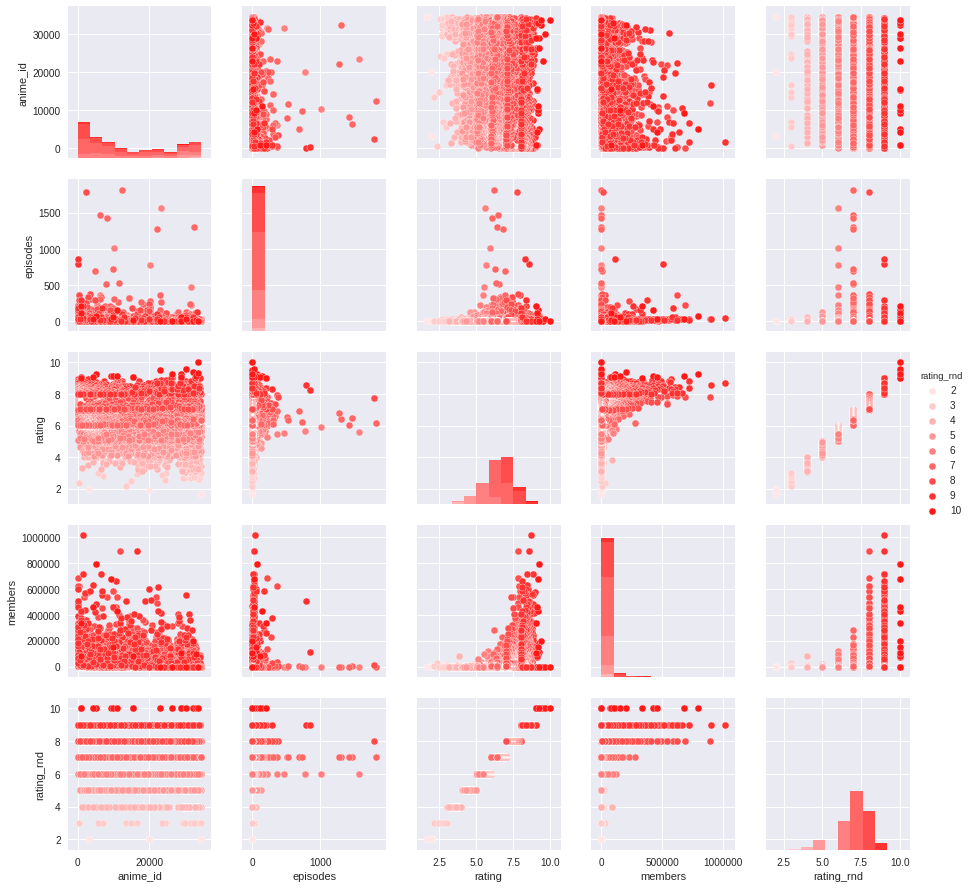

In [43]:

# put ratings in 10 bins 1 to 10 for visualization
anime['rating_rnd'] = pd.cut(anime['rating'],bins=[0,1,2,3,4,5,6,7,8,9,10], labels=['1','2','3','4','5','6','7','8','9','10']).astype(int)
# draw pairplot of numeric columns of anime
sns.pairplot(anime,hue='rating_rnd', palette=sns.light_palette('red',10))
# remove temp column
anime.drop('rating_rnd',axis=1, inplace=True)

# effect of number of members on anime rating
# - higher rating <=> higher number of members
# - some anime with rating > 9 but members count low,\ 

In [ ]:
# visualisation 
from pandas.plotting import parallel_coordinates
anime_features['rating_rnd'] = pd.cut(anime_features['rating'],bins=[0,1,2,3,4,5,6,7,8,9,10], labels=['1','2','3','4','5','6','7','8','9','10']).astype(int)
parallel_coordinates(anime_features[[u'Adventure', u'Cars', u'Comedy', u'Dementia', u'Demons', u'Drama',
       u'Fantasy', u'Game',u'Historical',
       u'Horror',u'rating_rnd']], 'rating_rnd')

In [155]:
genre_info = pd.DataFrame()

for feature in anime_features.columns:
    print(str(feature) + " avg: " + str(anime[anime_features[feature] == 1].mean()['rating']))
#anime_features.corr()   
#adventure = anime_features['Adventure'] == 1
#anime[adventure]

Action avg: 6.78304935711
Adventure avg: 6.74107745639
Cars avg: 6.46861111111
Comedy avg: 6.62368396555
Dementia avg: 5.02743582584
Demons avg: 6.67611603202
Drama avg: 6.9720019317
Ecchi avg: 6.66813664824
Fantasy avg: 6.67222962958
Game avg: 6.76932996892
Harem avg: 6.96304534042
Hentai avg: 6.18263958423
Historical avg: 6.74520189569
Horror avg: 6.4298432721
Josei avg: 7.42304811485
Kids avg: 6.11480776038
Magic avg: 6.79935710353
Martial Arts avg: 6.81768007811
Mecha avg: 6.64381477734
Military avg: 6.99613540321
Music avg: 5.93868879001
Mystery avg: 7.22113378527
Parody avg: 6.49900170907
Police avg: 7.11685672442
Psychological avg: 7.00688936277
Romance avg: 6.99398425892
Samurai avg: 6.85416530001
School avg: 6.9634068725
Sci-Fi avg: 6.70104163743
Seinen avg: 6.9637456209
Shoujo avg: 6.87346317525
Shoujo Ai avg: 6.97676907456
Shounen avg: 7.05229275037
Shounen Ai avg: 6.94493877998
Slice of Life avg: 6.73157691034
Space avg: 6.68042320355
Sports avg: 6.76994273406
Super Power a

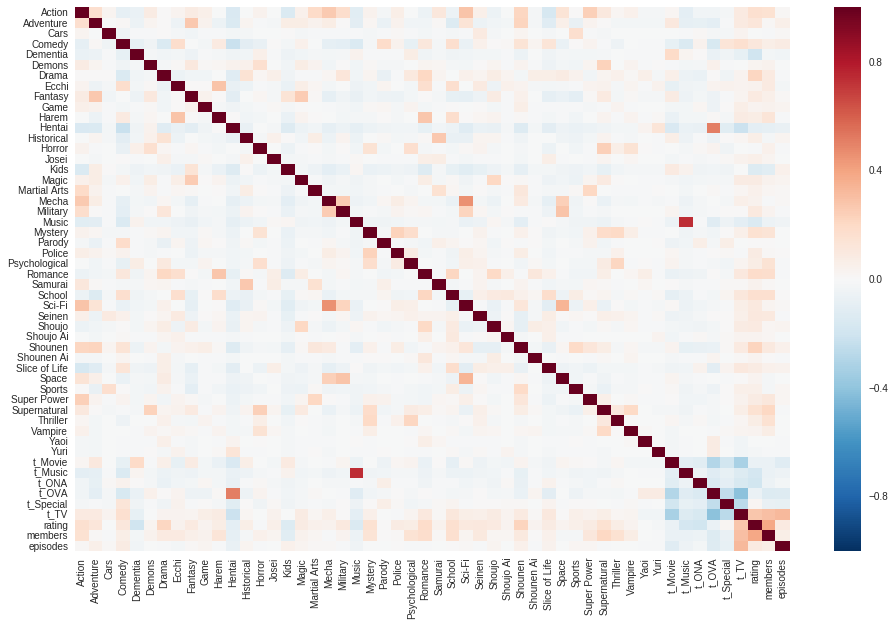

In [47]:
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(anime_features.corr())

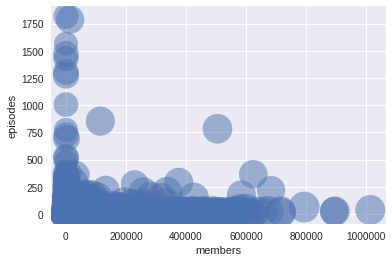

In [26]:
# user anime watching data
from sklearn.preprocessing import normalize
members_nrml = normalize(anime['members'].values.reshape(-1, 1))
anime.plot(kind='scatter', x='members', y='episodes', s=anime['rating']*100, alpha=0.5);

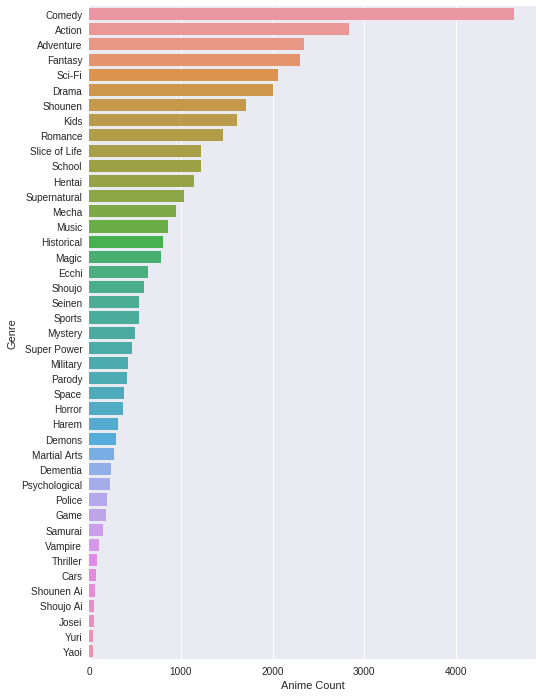

In [21]:
# analyzing genre data
import collections
g_list = [val.strip() for gen in anime['genre'].str.split(",") if type(gen) != float for val in gen]
genre_counter = collections.Counter(g_list)
genres = pd.DataFrame.from_dict(genre_counter, orient='index').reset_index().rename(columns={'index':'genre', 0:'count'})
genres.sort_values('count', ascending=False, inplace=True)

f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x="count", y="genre", data=genres)
ax.set(ylabel='Genre',xlabel="Anime Count")


In [ ]:

sns.lmplot('anime_w', 'anime_nr', user_data, fit_reg=False, )
#sns.lmplot('anime_w', 'anime_r', user_data, fit_reg=False)
#user_data.hist('anime_w', bins=25)
#user_data[user_data['anime_w'] > 2000].sort_values(by='anime_r', ascending=False)
#user_data.plot()
#user_anime_ids = 
user_anime_ids  = list(rating[rating['user_id']== 28521]['anime_id'])
anime[anime.anime_id in user_anime_ids]
#user_anime_list = anime.anime_id.isin(user_anime_ids)
#user_anime_list

#### Observation:
    - in order to perform CF on full dataset, we require matrix of 7.8m x 7.8m 
    options:
        i) take sample dataset to perform CF
            - animes rated by a specific number of users (i.e. n> 50: to reduce dataset but increase user behavior detection
        ii) find a way to reduce matrix or handle large matrix in python
            - PyTable : to store tables on disk
            - Scipy : sparse matrix

### Data Mining

Idea:
    - split genres using dummies variables
    - perform eigen vector analysis to find out PC count
    - perform PCA with n_components
    - combine transformed matrix with rest of the features (i.e. type, rating, member, name, count)
    
    does it work?

### Dimensionality Reduction 
    Here I'll try to perform latent factor analysis and clustering on:
        - Anime (attributes) Feature Matrix
            To see if I can reduce dimensions of anime features data
        - User-Anime Rating Matrix
            To find out pattern or relations in data. 
            
    Select Dimensionality Reduction method using GridSearchCV.
    options:
    Scale: StandardScaler, MinMax, Absolute etc
    MF: PCA, SVD, LDA, 
    
    
    Algorithms:
        - KernelPCA is an extension of PCA which achieves non-linear dimensionality reduction through the use of kernels (see Pairwise metrics, Affinities and Kernels). It has many applications including denoising, compression and structured prediction (kernel dependency estimation).
        - SparsePCA is a variant of PCA, with the goal of extracting the set of sparse components that best reconstruct the data.

In [48]:
# EDA using Unsupervised techniques
# imports
import matplotlib.pyplot as plt
import pandas as pd

# To scale/normalize data
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

# Latent Factor Models
from sklearn.decomposition import NMF,TruncatedSVD, PCA, SparsePCA, FactorAnalysis, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn import kernel_approximation

# visualisation 
from pandas.plotting import parallel_coordinates

In [8]:
# Create user-item rating sparse matrix
from scipy import sparse

# Get unique user_id
user_list = list(np.sort(rating.user_id.unique())) 

# Get unique anime_id
anime_list = list(rating.anime_id.unique())  

# Get Anime ratings
rating_list = rating.rating.tolist() 

# Get the associated users indices
users_cc = rating.user_id.astype('category', categories = user_list).cat.codes 

# Get the associated anime indices
anime_cc = rating.anime_id.astype('category', categories = anime_list).cat.codes 

# Create a sparse coordinate matrix
rating_sparse = sparse.coo_matrix((rating_list, (users_cc, anime_cc)), shape=(len(user_list), len(anime_list)))

# calculating matrix sparsity
matrix_size = rating_sparse.shape[0]*rating_sparse.shape[1] # Number of possible interactions in the matrix
num_ratings = len(rating_sparse.nonzero()[0]) # Number of anime interacted with
sparsity = 100*(1 - (num_ratings/float(matrix_size)))

print("Info:")
print("Users:\t\t\t" + str(rating_sparse.shape[0]))
print("Anime:\t\t\t" + str(rating_sparse.shape[1]))
print("# of Ratings:\t\t" + str(num_ratings))
print("Matrix Size:\t\t" + str(matrix_size))
print("Matrix sparsity:\t" + str(sparsity))


Info:
Users:			69600
Anime:			9893
# of Ratings:		6337147
Matrix Size:		688552800
Matrix sparsity:	99.0796425488


In [49]:
# Scale Data

# 1. Anime feature matrix
# scaling data
anime_feature_mat_std  = StandardScaler().fit_transform(anime_features)
# normalize data
anime_feature_mat_nrml = normalize(anime_features) 
anime_feature_mat_mm = MinMaxScaler().fit_transform(anime_features)

# 2. User-Item Rating Matrix 
# no need for scaling or normalizations 
# convert coo matrix to csr and perform scaling and normalization
#rating_sparse_std      = StandardScaler(with_mean=False).fit_transform(rating_sparse.tocsc())
#rating_sparse_nrml     = normalize(rating_sparse.tocsr())


#### Note: 
Awesome link to understand Standardizing and Normalizing:http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#standardizing-and-normalizing---how-it-can-be-done-using-scikit-learn

In [50]:
# Calculating Eigenvectors and eigenvalues  Cov matirx
feature_mat = anime_feature_mat_std # genre_list
mean_vec = np.mean(feature_mat, axis=0)
cov_mat = np.cov(feature_mat.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Creating a list of (eigenval, eigenvec) tuples
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)

exp_var = [ (i/tot)*100 for i in sorted(eig_vals,reverse=True)]

cum_exp_var = np.cumsum(exp_var)
len(exp_var)

52

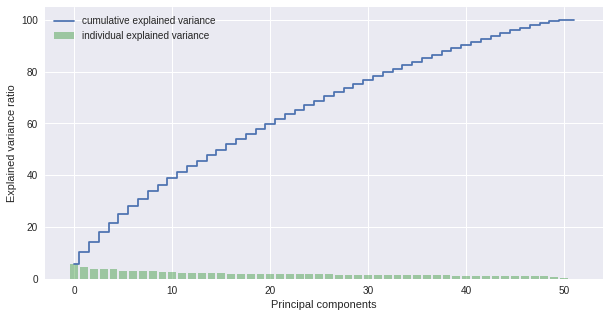

In [51]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.bar(range(len(exp_var)), exp_var, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(exp_var)), np.cumsum(exp_var), where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

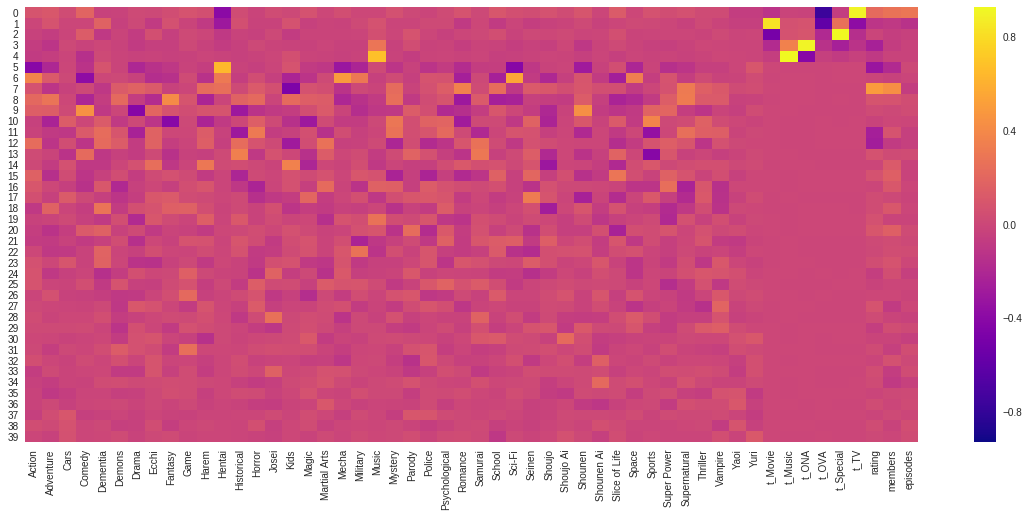

In [149]:
# kernel_approximation.

# results with PCA, RandamizedPCA, TruncatedSVD looks similar
#pca = PCA()
#rpca = PCA(svd_solver='randomized')
#spca = SparsePCA()
#tsvd = TruncatedSVD(50)

# NMF with min max normalization is totally different from previous algos
#nmf = NMF()

fa = FactorAnalysis(n_components=40)
#lda = LDA(n_components=92)
#kpca = KernelPCA(fit_inverse_transform=True, gamma=10)

feature_matrix = anime_feature_mat_std
model = fa

# Fit the model & Transform feature_matrix
transform_matrix = model.fit_transform(feature_matrix)

#heatmap to show correlation of pca.components_ with original columns
df_comp = pd.DataFrame(model.components_,columns=anime_features.columns)
plt.figure(figsize=(20,8))
sns.heatmap(df_comp,cmap='plasma',)
#sns.clustermap(df_comp,cmap='plasma',)

In [ ]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
estimator = model

plt.figure(figsize=(10, 5))
plt.bar(range(len(estimator.explained_variance_)), estimator.explained_variance_, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(estimator.explained_variance_)), np.cumsum(estimator.explained_variance_), where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

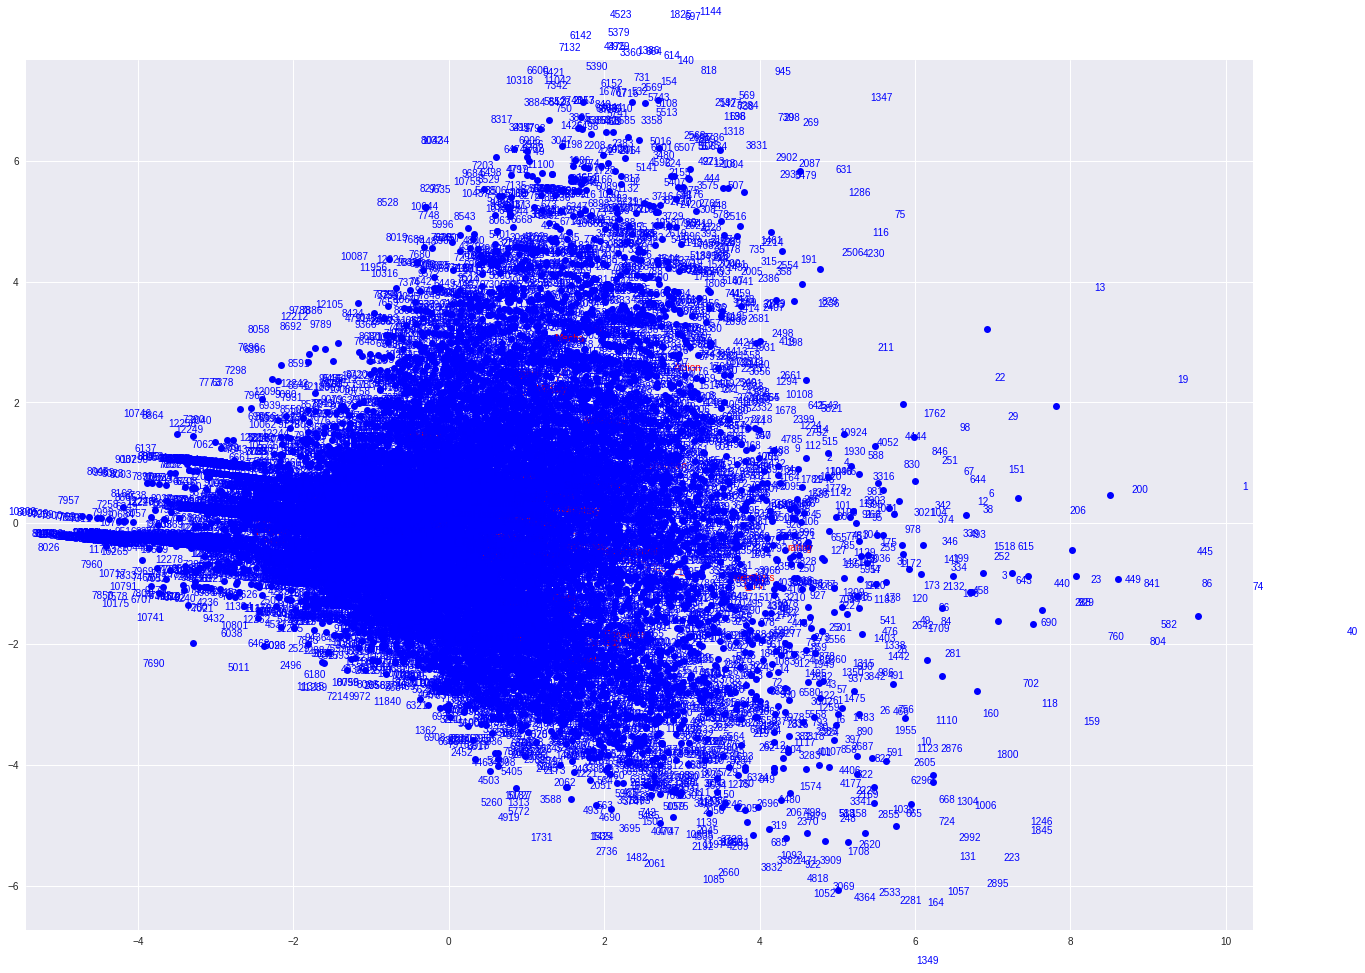

In [57]:
# Biplot visualization of PCs and Data
estimator = model
transformed_m = transform_matrix

xvector = estimator.components_[0] # see 'prcomp(my_data)$rotation' in R
yvector = estimator.components_[1]

xs = transformed_m[:,0] # see 'prcomp(my_data)$x' in R
ys = transformed_m[:,1]


## visualize projections
    
## Note: scale values for arrows and text are a bit inelegant as of now,
##       so feel free to play around with them
plt.figure(figsize=(22,16))
for i in range(len(xvector)):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(anime_features.columns.values)[i], color='r')

for i in range(len(xs)):
# circles project documents (ie rows from csv) as points onto PC axes
    plt.plot(xs[i], ys[i], 'bo')
    plt.text(xs[i]*1.2, ys[i]*1.2, list(anime_features.index)[i], color='b')

plt.show()

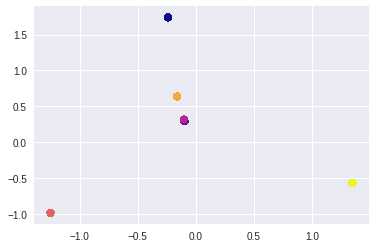

In [152]:
#sns.plt.scatter(pca.components_[1], pca.components_[4])
sns.plt.scatter(transform_matrix[:,0], transform_matrix[:,1],cmap='plasma', c=anime.type.astype('category',anime.type.unique()).cat.codes,alpha=0.5)
#sns.plt.scatter(transformed[:,1], transformed[:,2],c='b',alpha=0.5)


In [ ]:
transformed = transformed2
plt.scatter(transformed[genre_feature['Comedy']==1,0],transformed[genre_feature['Comedy']==1,1], c='r')
plt.scatter(transformed[genre_feature['Action']==1,0],transformed[genre_feature['Action']==1,1], c='g')
plt.scatter(transformed[(genre_feature['Comedy']==0) & (genre_feature['Action']==0) & (genre_feature['Sci-Fi']==0),0],transformed[(genre_feature['Comedy']==0) & (genre_feature['Action']==0) & (genre_feature['Sci-Fi']==0),1], c='y')

plt.scatter(transformed[genre_feature['Sci-Fi']==1,0],transformed[genre_feature['Sci-Fi']==1,1], c='b')


In [11]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((rating_sparse*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

No handlers could be found for logger "implicit"


### Clustering 
    Using elbow method on KMeans, we can see that k will be 6.

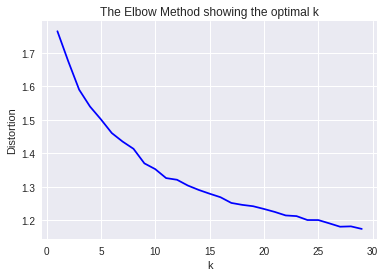

In [70]:
# https://pythonprogramminglanguage.com/kmeans-elbow-method/
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# create new plot and data
plt.plot()
X = anime_feature_mat_mm
#X = rating_sparse  # takes too much time and memory

# k means determine k
distortions = []
K = range(1,30)
# K = [100,200,300]  # for user-item sparse
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [101]:
# KMeans clustering
from sklearn.cluster import KMeans
k = 11 #  9, 11, 15 
kmeans = KMeans(n_clusters = k) # k = 6 , 11, 14, 16

kmeans.fit(X)
labels = kmeans.labels_

In [102]:
for label in range(0,k):
    print(str(label) + " count: " + str((labels==label).sum()) )

0 count: 486
1 count: 778
2 count: 2116
3 count: 724
4 count: 818
5 count: 1928
6 count: 631
7 count: 926
8 count: 1524
9 count: 1518
10 count: 756


In [98]:
anime[labels==6]
# anime in 3rd cluster seems to be the top ranking animes

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.370000,200630
11,28851,Koe no Katachi,"Drama, School, Shounen",Movie,1.0,9.050000,102733
15,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1.0,8.930000,466254
35,431,Howl no Ugoku Shiro,"Adventure, Drama, Fantasy, Romance",Movie,1.0,8.740000,333186
45,4282,Kara no Kyoukai 5: Mujun Rasen,"Action, Drama, Mystery, Romance, Supernatural,...",Movie,1.0,8.680000,111074
60,10408,Hotarubi no Mori e,"Drama, Romance, Shoujo, Supernatural",Movie,1.0,8.610000,197439
71,578,Hotaru no Haka,"Drama, Historical",Movie,1.0,8.580000,174878
102,11981,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku n...,"Drama, Magic, Psychological, Thriller",Movie,1.0,8.500000,135735
107,11979,Mahou Shoujo Madoka★Magica Movie 2: Eien no Mo...,"Drama, Magic, Psychological, Thriller",Movie,1.0,8.490000,85361
130,32,Neon Genesis Evangelion: The End of Evangelion,"Dementia, Drama, Mecha, Psychological, Sci-Fi",Movie,1.0,8.450000,215630


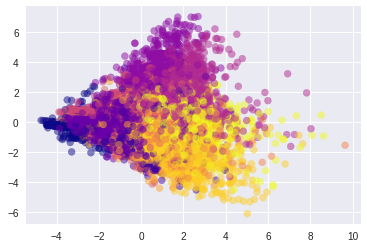

In [127]:
# Plot the scatter digram
sns.plt.scatter(transformed_m[:,0], transformed_m[:,1],cmap='plasma', c=labels,alpha=0.5)


In [ ]:
sns.pairplot(pcs_df, hue='c_labels', palette= 'Dark2', diag_kind='kde',size=1.85)
# plt.scatter(transformed[:,0], transformed[:,1], c=labels, cmap='rainbow', alpha=0.5)

#### Feature Selection
    Create different feature vectors and matrix required to build models in section 4.
    
    There are almost 70k users and 10k anime. Creating a user-item rating matrix would result in a large and very sparse matrix of 70k x 10k. To efficient use resources I'll be using scipy's sparse matrix.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1)
name_vec = list(vectorizer.fit_transform(anime['name']).toarray())


In [9]:
# Create user-item rating sparse matrix
from scipy import sparse

# Get unique user_id
user_list = list(np.sort(rating.user_id.unique())) 

# Get unique anime_id
anime_list = list(rating.anime_id.unique())  

# Get Anime ratings
rating_list = rating.rating.tolist() 

# Get the associated users indices
users_cc = rating.user_id.astype('category', categories = user_list).cat.codes 

# Get the associated anime indices
anime_cc = rating.anime_id.astype('category', categories = anime_list).cat.codes 

# Create a sparse coordinate matrix
rating_sparse = sparse.coo_matrix((rating_list, (users_cc, anime_cc)), shape=(len(user_list), len(anime_list)))

# calculating matrix sparsity
matrix_size = rating_sparse.shape[0]*rating_sparse.shape[1] # Number of possible interactions in the matrix
num_ratings = len(rating_sparse.nonzero()[0]) # Number of anime interacted with
sparsity = 100*(1 - (num_ratings/float(matrix_size)))

print("Info:")
print("Users:\t\t\t" + str(rating_sparse.shape[0]))
print("Anime:\t\t\t" + str(rating_sparse.shape[1]))
print("# of Ratings:\t\t" + str(num_ratings))
print("Matrix Size:\t\t" + str(matrix_size))
print("Matrix sparsity:\t" + str(sparsity))


Info:
Users:			69600
Anime:			9893
# of Ratings:		6337147
Matrix Size:		688552800
Matrix sparsity:	99.0796425488


## 4. Model, predict/recommendation.
    In this section I will try to create different models for recommendation system using different techniques from Data Mining.

###    4.1. Neighborhood Based 
    Recommendations based on similarity of users and/or items.
        

####        4.1.1 Content Based Recommendation
        - Comparing similarity between different anime based on features.
        - item-item recommendation using consine similarity for calculating similarity matrix.

    Procedure:
        - Standardize feature set 
        - Create item-item similarity matrix
        - Generate recommendation based on top similar items.
            

In [339]:
# features scaling
from sklearn.preprocessing import StandardScaler

anime_features_scaler = pd.DataFrame(StandardScaler().fit_transform(anime_features))

In [311]:
# item-item similarity based on item's attributes
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.metrics import jaccard_similarity_score

sim_mat = cosine_similarity(anime_features_scaler)
sim_mat.shape

(12207, 12207)

In [312]:
# to get anime IDs from partial name
# print(anime[anime.name.str.contains(partial)][['name','anime_id']])
all_anime_names = list(anime.name.values)
def get_id_from_partial_name(partial):
    for name in all_anime_names:
        if partial in name:
            print(name,all_anime_names.index(name))

In [313]:
# sim_mat.shape
def getSimilarItems(item, similarity_matrix, no_of_rec=5):
    sorted_items = np.argsort(similarity_matrix[item])
    reverse_sorted_items = sorted_items[::-1].tolist()
    top_items = reverse_sorted_items[1:no_of_rec+1]
    top_items_name = [anime.iloc[x]['name'] for x in top_items]
    return top_items_name[:no_of_rec]

#### Generating Recommendations:

In [336]:
get_id_from_partial_name('Kenichi')

('Shijou Saikyou no Deshi Kenichi', 260)
('Shijou Saikyou no Deshi Kenichi OVA', 510)
('Shijou Saikyou no Deshi Kenichi Specials', 2128)


In [338]:
getSimilarItems(260, sim_mat)

['Sakigake!! Otokojuku',
 'Kakutou Bijin Wulong: Rebirth',
 'Shijou Saikyou no Deshi Kenichi OVA',
 'Sakigake!! Otokojuku Movie',
 'Shijou Saikyou no Deshi Kenichi Specials']

In [340]:
# Dragon Ball: 346
getSimilarItems(346, sim_mat)

['Dragon Ball Z',
 'Naruto: Shippuuden',
 'Naruto',
 'Dragon Ball Kai',
 'Dragon Ball Super']

##### Content Based RS Observation:
    - we have a matrix of (observations, features) = (12294, 53)
    - in order to generate recommendations, find similarities of each item against all other items.
    - which result in a 12294 x 12294 similarity matrix (151142436 similarity values)
   

#### 4.1.2 Collaborative Filtering 
    Generate recommendations by finding similar users/items using (explicit) rating feedback (user-item rating matrix)
            
    Types:
        i) User-based Filtering
        Find similar users based on their rating data on anime. Recommend anime that other users rated highly.
            Steps: 
            1. Find k nearest neighbors for the user in the user-item matrix.
            2. Generate recommendation based on the items liked by the k nearest neighbors.
        
        Problem: Memory-based. Expensive online similarity computation.
        
        ii) Item-based Filtering
        Find similar items based on the rating of the users.
            Steps:
            1. Calculate similarities between items and keep for each item only the values for the k most similar items.
            2. Use the similarities to calculate a weighted sum of the user’s ratings for related items.
            Note: Regression can also be used to create the prediction.
            
        Properties of item-based filtering:
        - Model (reduced similarity matrix) is relatively small (N × k) and can be fully precomputed.
        - Item-based CF was reported to only produce slightly inferior results compared to user-based CF (Deshpande and Karypis, 2004).
        - Higher order models which take the joint distribution of sets of items into account are possible (Deshpande and Karypis, 2004).
        - Successful application in large scale systems
        
    Procedure:
        i) Get user-item rating matrix M
        ii) Normalize matrix and perform consine similarity for:
            User Based Filter:
            similarity between rows => sim(M) = 70k x 70k (too large for normal memory)
            Item Based Filter:
            similarity between cols => sim(M.transpose) = 10k x 10k
        iii) Nearest Neighbors
            - get indices and distance of user/item with its neighbors
        iv) Recommend 
            - In case of user based filtering, get nearest neighbors and recommend items from their history based on similarity coefficient.
        
    Pros: 
        i) Personalised Recommendation
        ii) Simple approach

    Cons:
        i) Memory & Computationality Expensive (i.e. sparse data handling, computations on large matrix)
        ii) Cold-start (i.e. system works poorly for user/items with no or less history)
             
Ref Links:
http://michael.hahsler.net/research/Recommender_SMU2011/slides/Recomm_2011.pdf

    Possible Solutions (other than hardware upgrade or algorithm change):
        i) Sample Data Set:
            To avoid memory issues, a sample of data can be used to make our model. However it may result in accuracy loss.
        ii) Use Sparse Matrix:
            To some extent memory issue can also be resolved using sparse matrix (where data is very sparse)


In [371]:
# Make sample data for user-based CF to avoid memory issue.

# Keep rating data for users who have watched anime between 50 and 1500
filtered_users = user_data[(user_data.anime_r > 50) & (user_data.anime_w < 1000)].index.tolist()
sub_rating = rating[rating.user_id.isin(filtered_users)]

# from sub_rating, keep anime with more than 25 user ratings 
anime_rcount = sub_rating.groupby('anime_id')['rating'].count()
sub_rating = sub_rating[sub_rating.anime_id.isin(anime_rcount[anime_rcount > 100].index.tolist())]

anime_ids = sub_rating.anime_id.astype('category', categories = sub_rating.anime_id.unique()).cat.codes
user_ids = sub_rating.user_id.astype('category', categories = sub_rating.user_id.unique()).cat.codes
rating_s = sub_rating.rating



In [7]:
def get_index_from_name(name):
    return anime[anime["name"]==name].index.tolist()[0]
    
def print_similar_animes(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(anime.ix[id]["name"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(anime.ix[id]["name"])


In [10]:
#def get_user_recommendations(user_id, num_of_rec = 10):
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# For sample data
#item_similarity = pairwise_distances(sub_rating)

# In case of Sparse Matrix 
rating_sparse = rating_sparse.tocsr()
#rating_sparse = normalize(rating_sparse, norm='l1', axis=1)


# Get user-user similarity matrix
# user_similarity = pairwise_distances(rating_sparse, metric='cosine') 

# Get item-item similarity matrix by normalizing columns (transpose of matrix) and calculating consine similarity
item_similarity_sparse = cosine_similarity(normalize(rating_sparse.transpose(), norm='l1', axis=1), dense_output=False)


/home/deeplearning/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [11]:
# item-item similarity based on ratings
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=6)
nbrs.fit(item_similarity_sparse)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=6, p=2, radius=1.0)

#### Generating Recommendations:

In [12]:
# search anime to get recommendations for
anime_name = "Blea"

# display related titles (that also exist in ratings)
anime[(anime.name.str.contains(anime_name)) & anime.anime_id.isin(rating.anime_id.unique().tolist())].head()



,anime_id,name,genre,type,episodes,rating,members
582,269,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,366.0,7.95,624055
946,8247,Bleach Movie 4: Jigoku-hen,"Action, Comedy, Shounen, Super Power, Supernat...",Movie,1.0,7.75,94074
1131,4835,Bleach Movie 3: Fade to Black - Kimi no Na wo ...,"Action, Comedy, Shounen, Super Power, Supernat...",Movie,1.0,7.66,122373
1274,2889,Bleach Movie 2: The DiamondDust Rebellion - Mo...,"Action, Adventure, Shounen, Supernatural",Movie,1.0,7.60,134739
1333,1686,Bleach Movie 1: Memories of Nobody,"Action, Adventure, Super Power",Movie,1.0,7.58,151598


In [13]:
# calc. and display nearest neighbor of anime_id

# Set anime_id to get distances and indices
anime_id = 269
# Angel Beats! 6547

# get similarity col/row index from anime name
similarity_col_id = anime_cc[rating[rating.anime_id == anime_id].index[0]]

# find nearest neighbors
distances, indices = nbrs.kneighbors(item_similarity_sparse[similarity_col_id])

# print indices and their distances
# first match is anime itself
print(distances)
indices

[[ 0.          1.54822235  1.64613411  1.80916427  1.93654043  2.02492846]]


array([[ 134,   35, 1059,    5, 1130, 1205]])

In [15]:
# display recommendations 

# get anime name from similarity
#anime[anime.anime_id == list(rating.loc[anime_cc[anime_cc == 448].index]['anime_id'])[0]]


# get anime list from indices
temp_list = anime_cc[anime_cc.isin(indices[0][1:])]
anime[anime.anime_id.isin(rating.loc[temp_list.drop_duplicates().index]['anime_id'].tolist())]

,anime_id,name,genre,type,episodes,rating,members
175,1604,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",TV,203.0,8.37,258103
288,6702,Fairy Tail,"Action, Adventure, Comedy, Fantasy, Magic, Sho...",TV,175.0,8.22,584590
476,9513,Beelzebub,"Action, Comedy, Demons, School, Shounen, Super...",TV,60.0,8.04,217752
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297
946,8247,Bleach Movie 4: Jigoku-hen,"Action, Comedy, Shounen, Super Power, Supernat...",Movie,1.0,7.75,94074


#### To-do: Implement Collaborative Filtering using "Weighter Slop One" Recommendations 

Reference Book: Data Mining Ch # 3

### Latent Factor Modeling
    Matrix Factorization:
        1. SVD
        - Use Incremental SVD to add new users/items without recomputing the whole SVD (Sarwar et al., 2002).
        - Good solutions can be found by stochastic gradient descent or alternating least squares (Koren et al., 2009).
        

Reference Link: https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

In [10]:
# train test split data 
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [ ]:
train, test = train_test_split(rating_sparse.tocsr())

In [ ]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(rating_sparse.tocsr(), k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, rating_sparse)))

In [ ]:
svds()